In [ ]:
import gdown

# Link to the Google Drive file
train_file_id = '1jkhzPTO4PFcmUlqr9PzjWCo1gvi_kDkL'
train_url = f'https://drive.google.com/uc?export=download&id={train_file_id}'
test_file_id = '1VUEKY1sbWLspQdu07UKE3ho5J6NrE4bt'
test_url = f'https://drive.google.com/uc?export=download&id={test_file_id}'

# Download the file using gdown
gdown.download(train_url, '/content/train_data.npz', quiet=False)
gdown.download(test_url, '/content/test_data.npz', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1jkhzPTO4PFcmUlqr9PzjWCo1gvi_kDkL
From (redirected): https://drive.google.com/uc?export=download&id=1jkhzPTO4PFcmUlqr9PzjWCo1gvi_kDkL&confirm=t&uuid=11eb0c64-3f58-4531-925d-f770efc246f9
To: /content/train_data.npz
100%|██████████| 553M/553M [00:08<00:00, 62.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1VUEKY1sbWLspQdu07UKE3ho5J6NrE4bt
From (redirected): https://drive.google.com/uc?export=download&id=1VUEKY1sbWLspQdu07UKE3ho5J6NrE4bt&confirm=t&uuid=ee014a15-7f52-493b-9c2f-17737638c757
To: /content/test_data.npz
100%|██████████| 92.1M/92.1M [00:00<00:00, 126MB/s]


'/content/test_data.npz'

In [ ]:
import numpy as np
import tensorflow as tf
#import keras_tuner as kt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the train and test data from .npz files
train_data = np.load('train_data.npz')
train_images = train_data['images']
train_labels = train_data['labels']

test_data = np.load('test_data.npz')
test_images = test_data['images']
test_labels = test_data['labels']

# Normalize images to [0, 1] range
train_images = train_images / 255.0
test_images = test_images / 255.0

# Check data information
print("Number of training examples:", len(train_images))
print("    Number of test examples:", len(test_images))
print("           Image dimensions:", train_images[0].shape)
print("          Number of classes:", len(np.unique(train_labels)))

Number of training examples: 697932
    Number of test examples: 116323
           Image dimensions: (28, 28, 1)
          Number of classes: 62


In [ ]:
# Define the SpinalBlock layer
class SpinalBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size_local, kernel_size_global, regularizer_strength=0.01):
        super(SpinalBlock, self).__init__()
        # Local path: Fine-grained features
        self.local_conv = Conv2D(filters, kernel_size_local, activation='relu',
                                  padding='same', kernel_regularizer=regularizers.l2(regularizer_strength))
        self.local_bn = BatchNormalization()

        # Global path: Coarse features
        self.global_conv = Conv2D(filters, kernel_size_global, activation='relu',
                                   padding='same', kernel_regularizer=regularizers.l2(regularizer_strength))
        self.global_bn = BatchNormalization()

    def call(self, inputs, training=False):
        # Process input through local and global paths
        local_features = self.local_conv(inputs)
        local_features = self.local_bn(local_features, training=training)

        global_features = self.global_conv(inputs)
        global_features = self.global_bn(global_features, training=training)

        # Combine local and global features (you can also experiment with concatenation)
        combined = local_features + global_features
        return combined


    '''

    def compute_output_shape(self, input_shape):
        """
        This function computes the output shape of the SpinalBlock layer.
        The output shape will be the same as the input shape (assuming same padding).
        """
        # Assuming the input shape is of the form (batch_size, height, width, channels)
        # The output shape after convolution will still be (height, width, filters) for each path
        height, width, channels = input_shape[1], input_shape[2], input_shape[3]

        # The output size for convolution with 'same' padding is the same as the input size
        return (input_shape[0], height, width, self.filters)

    def get_config(self):
        # Get the configuration of the layer
        config = super(SpinalBlock, self).get_config()

        # Remove unwanted arguments (e.g., trainable, dtype)
        unwanted_args = ['trainable', 'dtype']
        for arg in unwanted_args:
            if arg in config:
                config.pop(arg)

        # Return the filtered configuration
        return config

    @classmethod
    def from_config(cls, config):
        # Instantiate the model with the config arguments
        return cls(**config)
'''
# Define the CNN model with SpinalNet-style blocks
class SpinalNetCNN(tf.keras.Model):
    def __init__(self, num_classes=62, regularizer_strength=0.01, **kwargs):
        # Ignore 'trainable', 'dtype', and other unwanted arguments
        self._trainable = kwargs.pop('trainable', True)  # Just ignore the 'trainable' argument
        self._dtype = kwargs.pop('dtype', tf.float32)  # Just ignore the 'dtype' argument

        super(SpinalNetCNN, self).__init__(**kwargs)  # Pass the remaining arguments to the parent class

        # Define the layers
        self.block1 = SpinalBlock(32, kernel_size_local=(6, 6), kernel_size_global=(1, 1), regularizer_strength=regularizer_strength)
        self.pool1 = MaxPooling2D(pool_size=(2, 2))

        self.block2 = SpinalBlock(64, kernel_size_local=(4, 4), kernel_size_global=(1, 1), regularizer_strength=regularizer_strength)
        self.pool2 = MaxPooling2D(pool_size=(2, 2))

        self.block3 = SpinalBlock(128, kernel_size_local=(3, 3), kernel_size_global=(1, 1), regularizer_strength=regularizer_strength)

        # Global Average Pooling
        self.global_pool = GlobalAveragePooling2D()

        # Fully connected layers
        self.fc1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer_strength))
        self.dropout1 = Dropout(0.3)

        # Output layer
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.block1(inputs, training=training)
        x = self.pool1(x)

        x = self.block2(x, training=training)
        x = self.pool2(x)

        x = self.block3(x, training=training)

        x = self.global_pool(x)

        x = self.fc1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x

    '''def get_config(self):
        # Get the configuration of the layer
        config = super(SpinalBlock, self).get_config()

        # Remove unwanted arguments (e.g., trainable, dtype)
        unwanted_args = ['trainable', 'dtype']
        for arg in unwanted_args:
            if arg in config:
                config.pop(arg)

        # Return the filtered configuration
        return config

    @classmethod
    def from_config(cls, config):
        # Instantiate the model with the config arguments
        return cls(**config)'''

# Instantiate the model
model = SpinalNetCNN(num_classes=62)

# Compile the model with Exponential Decay learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00248)
#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Fit the model
datagen.fit(train_images)
model.fit(datagen.flow(train_images, train_labels, batch_size=128),
              epochs=10,
              validation_data=(test_images, test_labels),
              callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Save the model
model.save('spinalnet_emnist.h5')
model.save('spinalnet_emnist.keras')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 278s 48ms/step - accuracy: 0.7239 - loss: 1.5083 - val_accuracy: 0.7411 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 2/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 255s 47ms/step - accuracy: 0.8128 - loss: 0.7452 - val_accuracy: 0.8097 - val_loss: 0.7219 - learning_rate: 9.0000e-04
Epoch 3/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 253s 45ms/step - accuracy: 0.8208 - loss: 0.6837 - val_accuracy: 0.7909 - val_loss: 0.7445 - learning_rate: 9.0000e-04
Epoch 4/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 257s 44ms/step - accuracy: 0.8246 - loss: 0.6579 - val_accuracy: 0.7664 - val_loss: 0.8224 - learning_rate: 8.1000e-04
Epoch 5/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 266s 45ms/step - accuracy: 0.8276 - loss: 0.6309 - val_accuracy: 0.7848 - val_loss: 0.7398 - learning_rate: 8.1000e-04
Epoch 6/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 244s 45ms/step - accuracy: 0.8290 - loss: 0.6232 - val_accuracy: 0.8190 - val_loss: 0.6294 - learning_rate: 7.2900e-04
Epoch 7/10
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 268s 46

Test Loss: 0.5385
Test Accuracy: 84.36%


# Model: spinal_net_cnn

| **Layer (type)**      | **Output Shape**         | **Param #**  |
|-----------------------|--------------------------|--------------|
| **spinal_block**       | ?                        | 1,504        |
| **max_pooling2d**     | (None, 14, 14, 32)       | 0            |
| **spinal_block_1**     | ?                        | 35,456       |
| **max_pooling2d_1**   | (None, 7, 7, 64)         | 0            |
| **spinal_block_2**     | ?                        | 83,200       |
| **globalpooling2d**    | (None, 128)              | 0            |
| **dense**             | (None, 128)              | 16,512       |
| **dropout**           | (None, 128)              | 0            |
| **dense_1**           | (None, 62)               | 7,998        |

---

### **Model Summary:**

- **Total params:** 432,219 (1.65 MB)  
- **Trainable params:** 143,774 (561.62 KB)  
- **Non-trainable params:** 896 (3.50 KB)  
- **Optimizer params:** 287,549 (1.10 MB)



In [ ]:
import gdown

# Link to the Google Drive file
model_file_id = '1R8gb0aKSUO3wTwquble1_MrCUlrmWBM_'
model_file_url = f'https://drive.google.com/uc?export=download&id={model_file_id}'
model_file_id2 = '1p5G87ZjJS9sjMQldjNdCZCWjWh5freu2'
model_file_url2 = f'https://drive.google.com/uc?export=download&id={model_file_id2}'

# Download the file using gdown
gdown.download(model_file_url, '/content/SpinalCNN_AgmuntedEMNIST.h5', quiet=False)
gdown.download(model_file_url2, '/content/SpinalCNN_AgmuntedEMNIST.keras', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1R8gb0aKSUO3wTwquble1_MrCUlrmWBM_
To: /content/SpinalCNN_AgmuntedEMNIST.h5
100%|██████████| 1.82M/1.82M [00:00<00:00, 27.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1p5G87ZjJS9sjMQldjNdCZCWjWh5freu2
To: /content/SpinalCNN_AgmuntedEMNIST.keras
100%|██████████| 1.81M/1.81M [00:00<00:00, 63.0MB/s]


'/content/SpinalCNN_AgmuntedEMNIST.keras'

In [ ]:
# Define the SpinalBlock layer
class SpinalBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size_local, kernel_size_global, regularizer_strength=0.01):
        super(SpinalBlock, self).__init__()
        # Local path: Fine-grained features
        self.local_conv = Conv2D(filters, kernel_size_local, activation='relu',
                                  padding='same', kernel_regularizer=regularizers.l2(regularizer_strength))
        self.local_bn = BatchNormalization()

        # Global path: Coarse features
        self.global_conv = Conv2D(filters, kernel_size_global, activation='relu',
                                   padding='same', kernel_regularizer=regularizers.l2(regularizer_strength))
        self.global_bn = BatchNormalization()

    def call(self, inputs, training=False):
        # Process input through local and global paths
        local_features = self.local_conv(inputs)
        local_features = self.local_bn(local_features, training=training)

        global_features = self.global_conv(inputs)
        global_features = self.global_bn(global_features, training=training)

        # Combine local and global features (you can also experiment with concatenation)
        combined = local_features + global_features
        return combined

    def compute_output_shape(self, input_shape):
        """
        This function computes the output shape of the SpinalBlock layer.
        The output shape will be the same as the input shape (assuming same padding).
        """
        # Assuming the input shape is of the form (batch_size, height, width, channels)
        # The output shape after convolution will still be (height, width, filters) for each path
        height, width, channels = input_shape[1], input_shape[2], input_shape[3]

        # The output size for convolution with 'same' padding is the same as the input size
        return (input_shape[0], height, width, self.filters)

    def get_config(self):
        # Get the configuration of the layer
        config = super(SpinalBlock, self).get_config()

        # Remove unwanted arguments (e.g., trainable, dtype)
        unwanted_args = ['trainable', 'dtype']
        for arg in unwanted_args:
            if arg in config:
                config.pop(arg)

        # Return the filtered configuration
        return config

    @classmethod
    def from_config(cls, config):
        # Instantiate the model with the config arguments
        return cls(**config)

# Define the CNN model with SpinalNet-style blocks
class SpinalNetCNN(tf.keras.Model):
    def __init__(self, num_classes=62, regularizer_strength=0.01, **kwargs):
        # Ignore 'trainable', 'dtype', and other unwanted arguments
        self._trainable = kwargs.pop('trainable', True)  # Just ignore the 'trainable' argument
        self._dtype = kwargs.pop('dtype', tf.float32)  # Just ignore the 'dtype' argument

        super(SpinalNetCNN, self).__init__(**kwargs)  # Pass the remaining arguments to the parent class

        # Define the layers
        self.block1 = SpinalBlock(32, kernel_size_local=(6, 6), kernel_size_global=(1, 1), regularizer_strength=regularizer_strength)
        self.pool1 = MaxPooling2D(pool_size=(2, 2))

        self.block2 = SpinalBlock(64, kernel_size_local=(4, 4), kernel_size_global=(1, 1), regularizer_strength=regularizer_strength)
        self.pool2 = MaxPooling2D(pool_size=(2, 2))

        self.block3 = SpinalBlock(128, kernel_size_local=(3, 3), kernel_size_global=(1, 1), regularizer_strength=regularizer_strength)

        # Global Average Pooling
        self.global_pool = GlobalAveragePooling2D()

        # Fully connected layers
        self.fc1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer_strength))
        self.dropout1 = Dropout(0.3)

        # Output layer
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.block1(inputs, training=training)
        x = self.pool1(x)

        x = self.block2(x, training=training)
        x = self.pool2(x)

        x = self.block3(x, training=training)

        x = self.global_pool(x)

        x = self.fc1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x

    def get_config(self):
        # Get the configuration of the layer
        config = super(SpinalBlock, self).get_config()

        # Remove unwanted arguments (e.g., trainable, dtype)
        unwanted_args = ['trainable', 'dtype']
        for arg in unwanted_args:
            if arg in config:
                config.pop(arg)

        # Return the filtered configuration
        return config

    @classmethod
    def from_config(cls, config):
        # Instantiate the model with the config arguments
        return cls(**config)

SpinalCNN = tf.keras.models.load_model('SpinalCNN_AgmuntedEMNIST.keras', custom_objects={'SpinalNetCNN': SpinalNetCNN})

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 30 variables whereas the saved optimizer has 57 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3636/3636 ━━━━━━━━━━━━━━━━━━━━ 154s 42ms/step


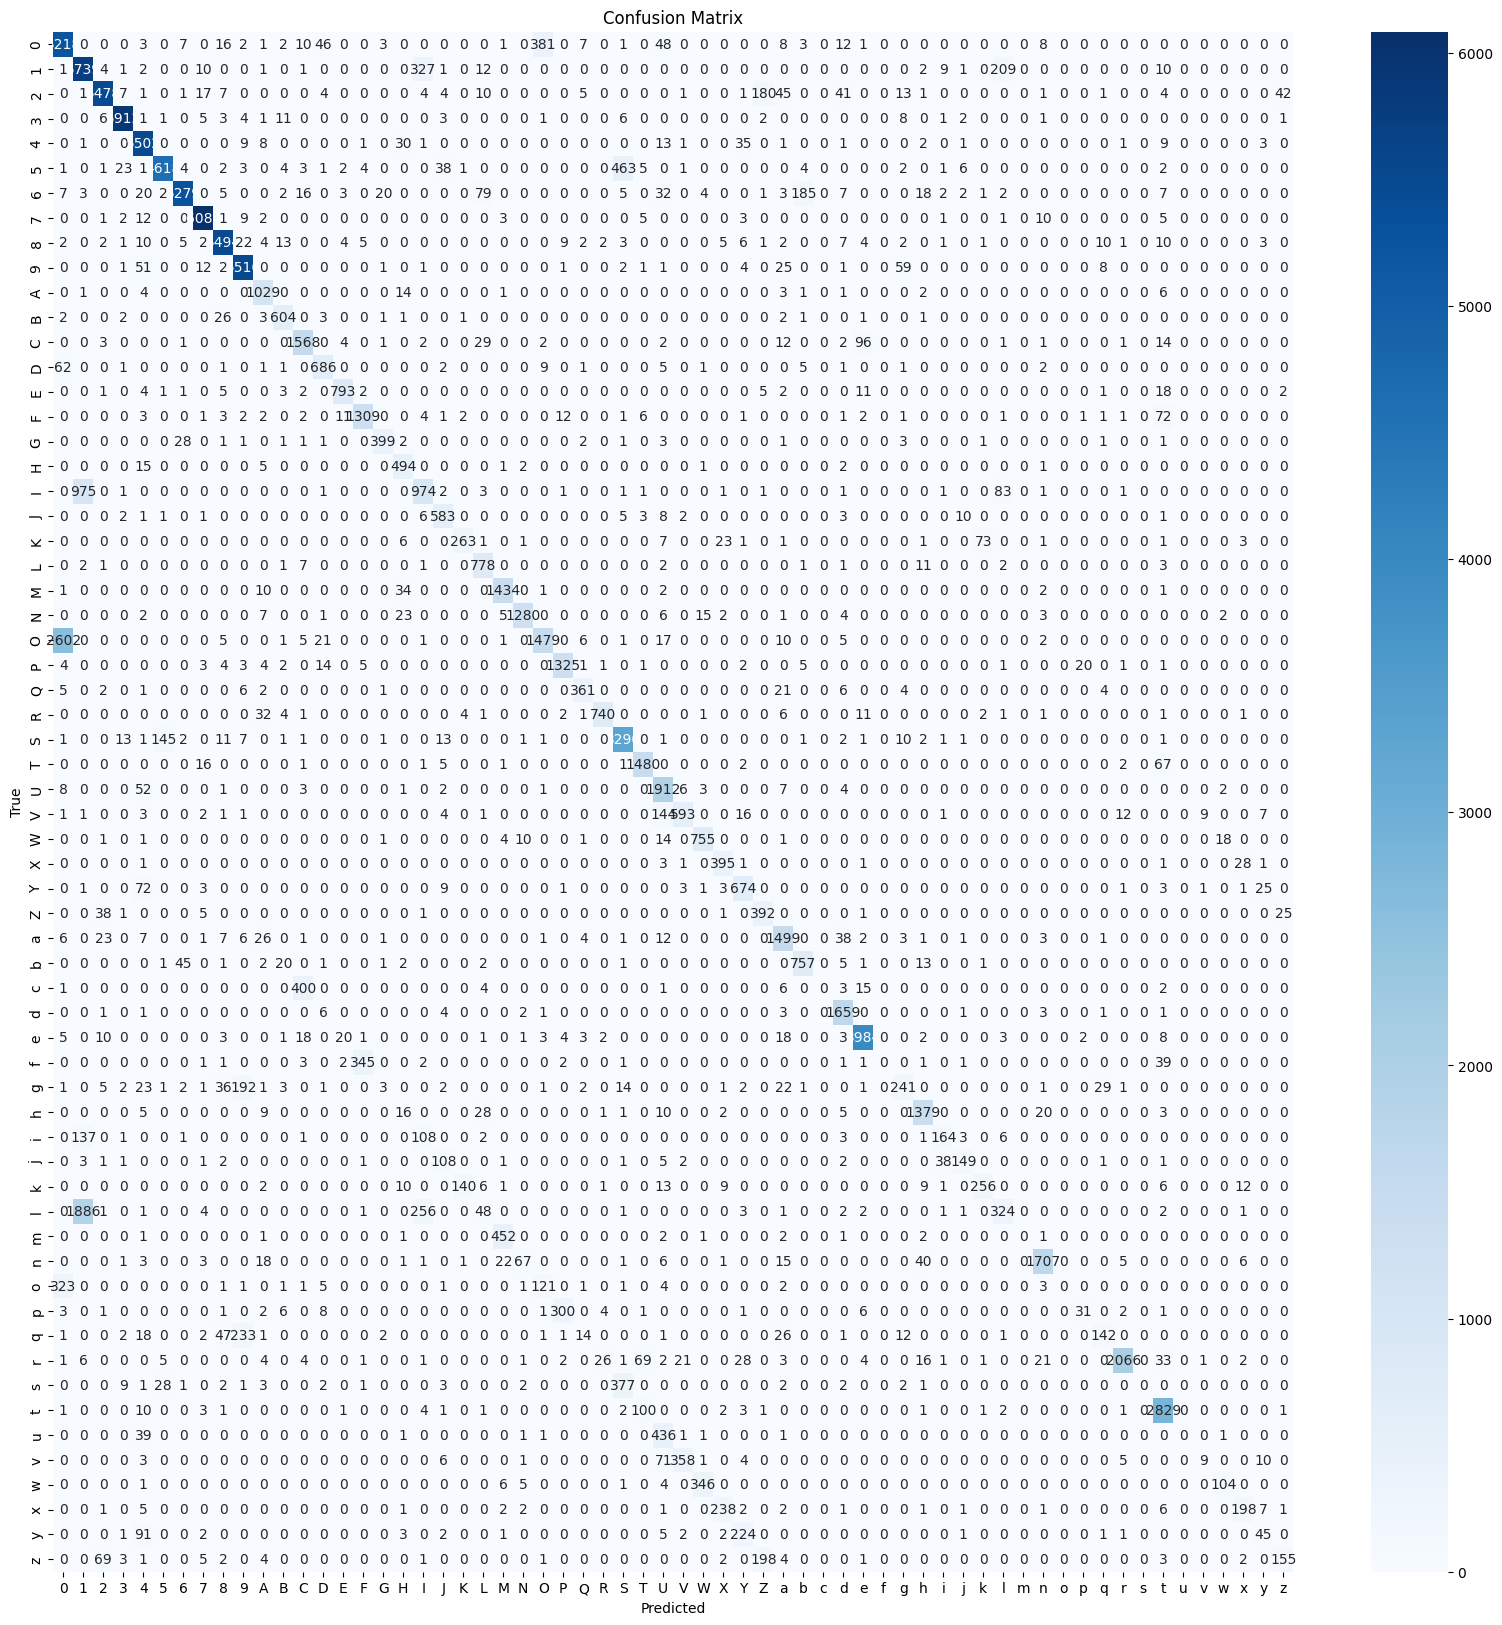

Accuracy of combined Keras model: 0.8436


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict the class probabilities for the test images
prob = SpinalCNN.predict(test_images)
# Get the predicted class labels (using argmax on probabilities)
label_pred = np.argmax(prob, axis=1)

cm = tf.math.confusion_matrix(test_labels, label_pred)

class_labels = {
     0: '0',  1: '1',  2: '2',  3: '3',  4: '4',  5: '5',  6: '6',  7: '7',  8: '8',  9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j',
    46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't',
    56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, [class_labels[i] for i in range(len(class_labels))])
plt.yticks(tick_marks + 0.5, [class_labels[i] for i in range(len(class_labels))])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(test_labels, label_pred)
print(f'Accuracy of combined Keras model: {accuracy:.4f}')

In [ ]:
# Initialize the metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Update the state of the metrics with true labels and predicted labels
precision_metric.update_state(test_labels, label_pred)
recall_metric.update_state(test_labels, label_pred)

# Compute Precision and Recall
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

# Compute F1 Score (manually calculated from Precision and Recall)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Precision: 0.9948
Recall: 0.9725
F1 Score: 0.9835


In [ ]:
# Ensure input shape is correct (for example, images should be in the form of (num_samples, height, width, channels))
print(f"Train image shape: {train_images.shape}")
print(f"Test image shape: {test_images.shape}")

Train image shape: (697932, 28, 28, 1)
Test image shape: (116323, 28, 28, 1)


In [ ]:
import joblib
import numpy as np

# Define batch size
batch_size = 32  # You can adjust this based on memory and computational capacity

# Initialize lists to store batch probabilities
SpinalCNN_probs_train = []
SpinalCNN_probs_test = []

# Perform batch prediction for training images
for i in range(0, len(train_images), batch_size):
    # Select the current batch
    batch_images = train_images[i:i + batch_size]
    print(f"Batch {i//batch_size + 1}: {batch_images.shape}")
    # Get the class probabilities for the batch
    batch_probs_train = SpinalCNN.predict(batch_images)

    # Append batch results to the list
    SpinalCNN_probs_train.append(batch_probs_train)

# Concatenate the list into a single array
SpinalCNN_probs_train = np.concatenate(SpinalCNN_probs_train, axis=0)

# Perform batch prediction for test images
for i in range(0, len(test_images), batch_size):
    # Select the current batch
    batch_images = test_images[i:i + batch_size]

    # Get the class probabilities for the batch
    batch_probs_test = SpinalCNN.predict(batch_images)

    # Append batch results to the list
    SpinalCNN_probs_test.append(batch_probs_test)

# Concatenate the list into a single array
SpinalCNN_probs_test = np.concatenate(SpinalCNN_probs_test, axis=0)

# Save the class probabilities using joblib
joblib.dump(SpinalCNN_probs_train, 'SpinalCNN_probs_train.pkl')  # Save train probabilities
joblib.dump(SpinalCNN_probs_test, 'SpinalCNN_probs_test.pkl')    # Save test probabilities

# Print the shapes of the saved probabilities
print(f"Saved train probabilities shape: {SpinalCNN_probs_train.shape}")
print(f"Saved test probabilities shape: {SpinalCNN_probs_test.shape}")


Batch 1: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Batch 2: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Batch 3: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Batch 4: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Batch 5: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Batch 6: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Batch 7: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Batch 8: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Batch 9: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Batch 10: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Batch 11: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Batch 12: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Batch 13: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Batch 14: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Batch 15: (32, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Batch 16: (32, 28, 28, 1)
1/1 ━━━━━

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# Assuming train_images and train_labels are already loaded
# Flatten the image data for Random Forest input
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_images.reshape(train_images.shape[0], -1), train_labels)

# Generate class probabilities using the Random Forest model
rf_probs_train = rf_classifier.predict_proba(train_images.reshape(train_images.shape[0], -1))  # Shape: (num_samples, num_classes)
rf_probs_test = rf_classifier.predict_proba(test_images.reshape(test_images.shape[0], -1))    # Shape: (num_samples, num_classes)

# Save the trained Random Forest model
joblib.dump(rf_classifier, 'rf_classifier_model.pkl')  # Save model to file

# Optionally, save the probabilities if needed
joblib.dump(rf_probs_train, 'rf_probs_train.pkl')
joblib.dump(rf_probs_test, 'rf_probs_test.pkl')

In [ ]:
from sklearn.linear_model import LogisticRegression

# Load the pre-trained SpinalNetCNN model
#SpinalCNN = tf.keras.models.load_model('SpinalCNN_AgmuntedEMNIST.keras', custom_objects={'SpinalNetCNN': SpinalNetCNN})
# Load the saved class probabilities
SpinalCNN_probs_train = joblib.load('SpinalCNN_probs_train.pkl')
SpinalCNN_probs_test = joblib.load('SpinalCNN_probs_test.pkl')

# Load the saved Random Forest model
#rf_classifier_loaded = joblib.load('rf_classifier_model.pkl')
# Load the saved probabilities (optional)
rf_probs_train = joblib.load('rf_probs_train.pkl')
rf_probs_test = joblib.load('rf_probs_test.pkl')

# Step 3: Stack the predictions from both models (CNN and Random Forest)
# Combining CNN and Random Forest probabilities (meta-features)
meta_features_train = np.hstack((SpinalCNN_probs_train, rf_probs_train))  # Shape: (num_samples, 2 * num_classes)
meta_features_test = np.hstack((SpinalCNN_probs_test, rf_probs_test))    # Shape: (num_samples, 2 * num_classes)

# Step 4: Train the meta-model (Logistic Regression)
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features_train, train_labels)

# Step 5: Evaluate the Stacked Model
# Get the final predictions from the meta-model using the stacked features
meta_predictions = meta_model.predict(meta_features_test)
final_accuracy = accuracy_score(test_labels, meta_predictions)

print(f"Final Accuracy of Stacked Model: {final_accuracy * 100:.2f}%")

# Optionally, you can save the meta-model for future use
import joblib
joblib.dump(meta_model, 'meta_model.pkl')  # Save the meta-model (Logistic Regression)